In [1]:
import jax.numpy as jnp
import jax
import numpy as np
from scipy.stats import qmc
from scipy.stats import lognorm, norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import simulation_alpha_stable_rqmc,stat



def prior_sample_init():
    """
    Tire 1  theta selon la loi a priori().
    Exemple: on suppose alpha ~ Uniform(1.1,2), beta ~ Uniform(-1,1),
             gamma ~ Lognormal(0,1), delta ~ Normal(0,1.5)
  
    """
   
    alpha = np.random.uniform(1.1, 2.0)   # on évite alpha < 0.1
    beta  = np.random.uniform(-1.0, 1.0)
    gamma= np.random.lognormal(mean=0, sigma=0.1)
    delta = np.random.normal(loc=0.0, scale=1.5)
    return np.array((alpha, beta, gamma, delta))

def g(teta):
    """
    Tire 1  theta selon la loi a priori(teta|teta i-1).
    Exemple: on suppose alpha ~ Uniform(0,2), beta ~ Uniform(-1,1),
             gamma ~ Lognormal(0,1), delta ~ Normal(0,1.5)
  
    """

    alpha_input, beta_input, gamma_input, delta_input=teta

    a_low  = max(1.1, alpha_input - 0.2) # on évite alpha < 0.1
    a_high = min(2.0, alpha_input + 0.2)
    alpha = np.random.uniform(a_low, a_high)  

    b_low  = max(-1.0, beta_input - 0.2)
    b_high = min( 1.0, beta_input + 0.2) 
    beta  = np.random.uniform(b_low, b_high)

    gamma = gamma_input * np.exp(np.random.normal(0., 0.1))


    delta = np.random.normal(loc=delta_input, scale=1.5)

   
    # log_gamma_prop = np.log(gamma_input) + np.random.normal(0.0, 0.3)
    # gamma   = np.exp(log_gamma_prop)         # always positive


    # delta = np.random.normal(delta_input, 1)


    return np.array((alpha, beta, gamma, delta))

def simulate_xi(teta):
    alpha_input, beta_input, gamma_input, delta_input=teta

    x=simulation_alpha_stable_rqmc(alpha_input, beta_input, gamma_input, delta_input,4096  )
    return x




def dist(s_sim, s_obs):
    """  L2 norm"""
    return np.linalg.norm(s_sim - s_obs, ord=2)
#------------------------------------------------Statistics summary end---------------------------------------------

def log_prior(teta):
    #calculate joint density of theta
    alpha_input, beta_input, gamma_input, delta_input=teta

    if not (1.1<alpha_input<2) or not (-1<beta_input<1) or  (gamma_input<=0):
        return -np.inf#force rejection
    #marginal densities:


    #in log 
    log_pdf_alpha=-np.log(2-1.1)
    log_pdf_beta=-np.log(2)
    log_pdf_gamma = lognorm.logpdf(gamma_input, s=0.1, scale=np.exp(0.0))#s=0.1 (sigma),scale=exp(mu)
    log_pdf_delta = norm.logpdf(delta_input,  loc=0.0, scale=1.5)


    # #in level
    # log_pdf_alpha=1/(2-1.1)
    # log_pdf_beta=1/(2)
    # log_pdf_gamma = lognorm.pdf(gamma_input, s=0.1, scale=np.exp(0))
    # log_pdf_delta = norm.pdf(delta_input,  loc=0.0, scale=1.5)





    #joint density=prod of marginal densities=sum of log of marginal densities
    return log_pdf_alpha+log_pdf_beta+log_pdf_gamma+log_pdf_delta
    # return log_pdf_alpha*log_pdf_beta*log_pdf_gamma*log_pdf_delta

def log_uniform_pdf(point,param,lb,up):
    #calculate pdf at point "point" at parameters "param"
    a_low  = max(lb, param - 0.2) 
    a_high = min(up, param + 0.2)

    if a_low<point<a_high:
        return -np.log(a_high-a_low)#pdf uniform
        # return 1/(a_high-a_low)#in level
    return -np.inf#force reject if out of the interval

def log_g(teta_point,teta_parameter):
    """ 
    evaluate pdf at point "point" | parameter theta
    """

    alpha_point, beta_point, gamma_point, delta_point=teta_point
    alpha_parameter, beta_parameter, gamma_parameter, delta_parameter=teta_parameter
    
    #evaluate first uniforms
    log_pdf_alpha=log_uniform_pdf(alpha_point,alpha_parameter,1.1,2)
    log_pdf_beta=log_uniform_pdf(beta_point,beta_parameter,-1,1)
    
    #then log of normal and lognormal
    log_pdf_gamma = lognorm.logpdf(gamma_point,
                          s=0.1,
                          scale=(gamma_parameter) )
    
    log_pdf_delta = norm.logpdf(delta_point,  loc=delta_parameter, scale=1.5)

 
    # log_pdf_gamma = lognorm.pdf(gamma_point, s=0.1, scale=np.exp(gamma_parameter))
    # log_pdf_delta = norm.pdf(delta_point,  loc=delta_parameter, scale=1.5)

    #joint density=prod of marginal densities=sum of log of marginal densities, just sum them up 
    return log_pdf_alpha+log_pdf_beta+log_pdf_gamma+log_pdf_delta
    # return log_pdf_alpha*log_pdf_beta*log_pdf_gamma*log_pdf_delta#in level
    

def abc_mcmc(y_obs,N,statistic,epsilon,init):
    #declare our matrix theta where we will store alpha beta delta gama
    theta=np.zeros((N,4))

    #initial good guess
    theta[0,:]=init

    sy=stat(statistic,y_obs)
    counts=0
    pbar = tqdm(range(1, N))
    for i in pbar:
        theta_new=g(theta[i-1,:])
        x_sim=simulate_xi(theta_new)
        sx=stat(statistic,x_sim)
        di=dist(sx,sy)
        # # DS.append(di)
        # print(di)

        if di<epsilon:
            # print("-")
            #if in log
            r=log_prior(theta_new)-log_prior(theta[i-1,:])+log_g(theta[i-1,:],theta_new)-log_g(theta_new,theta[i-1,:])
            

            #did not work
            # r=(log_prior(theta_new)/log_prior(theta[i-1,:]))*(log_g(theta[i-1,:],theta_new)/log_g(theta_new,theta[i-1,:]))
            alpha=min(1,np.exp(r))
            if np.random.rand() < alpha:
                #we accept here 
                # print("_________________________________")
                theta[i,:] = theta_new
                counts=counts+1
                
              
            else:
                #we reject here 
                theta[i,:] = theta[i-1,:]
        else:
            #we reject here 
                theta[i,:] = theta[i-1,:]
        pbar.set_description(f"Accepted: {counts}")
    return theta,counts


def descriptive(theta_posterior):
    #do some descriptive statistics 
    df = pd.DataFrame(theta_posterior, columns=["alpha", "beta", "gamma", "delta"])

    df.hist(bins=50, figsize=(10, 6))
    plt.suptitle("Marginal posterior distributions" )
    plt.show()

    mean = np.mean(theta_posterior, axis=0)
    ci95 = np.percentile(theta_posterior, [2.5, 97.5], axis=0)

    for name, m, ci in zip(["alpha", "beta", "gamma", "delta"], mean, ci95.T):
        print(f"{name:6s} mean = {m:.3f},  95% CI = [{ci[0]:.3f}, {ci[1]:.3f}]")





In [3]:

alpha = 1.7
beta = 0.5
gamma = 1.0
delta = 0.0
np.random.seed(1234)#just to reproduce same results (aligned with our report)
y_obs=simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n=4096, )


In [4]:
#s3-----------------------
np.random.seed(1234)#just to reproduce same results (aligned with our report)
init=prior_sample_init()
print("prior theta 0 used: ",init)#with this prior on theta[0,:] you do calculations
#if counts counter does not update then change prior init or epsilon 
theta_s3,counts_accept_s3=abc_mcmc(y_obs,1000,"s3",epsilon=1,init=init)
print(100*counts_accept_s3/1000,"% accepted for s2")
burn = int(0.2 * len(theta_s3))
theta_posterior_s3= theta_s3[burn:, :]#burin first "bad" oubservations

prior theta 0 used:  [ 1.27236751  0.24421754  1.15404215 -0.46897784]


Accepted: 263: 100%|██████████| 999/999 [01:15<00:00, 13.26it/s]

26.3 % accepted for s2


In [6]:
#s4-----------------------
np.random.seed(1234)#just to reproduce same results (aligned with our report)
init=prior_sample_init()
print("prior theta 0 used: ",init)#with this prior on theta[0,:] you do calculations
#if counts counter does not update then change prior init or epsilon 
theta_s4,counts_accept_s4=abc_mcmc(y_obs,1000,"s4",epsilon=0.15,init=init)
print(100*counts_accept_s4/1000,"% accepted for s4")
burn = int(0.2 * len(theta_s4))
theta_posterior_s4= theta_s4[burn:, :]#burin first "bad" oubservations

prior theta 0 used:  [ 1.27236751  0.24421754  1.15404215 -0.46897784]


Accepted: 312: 100%|██████████| 999/999 [01:35<00:00, 10.51it/s]

31.2 % accepted for s4


In [215]:
#s2-----------------------
np.random.seed(1234)#just to reproduce same results (aligned with our report)
init=prior_sample_init()
print("prior theta 0 used: ",init)#with this prior on theta[0,:] you do calculations
#if counts counter does not update then change prior init or epsilon 
theta_s2,counts_accept_s2=abc_mcmc(y_obs,1000,"s2",epsilon=0.5,init=init)
print(100*counts_accept_s2/1000,"% accepted for s2")
burn = int(0.2 * len(theta_s2))
theta_posterior_s2= theta_s2[burn:, :]#burin first "bad" oubservations

prior theta 0 used:  [ 1.27236751  0.24421754  1.15404215 -0.46897784]


Accepted: 127: 100%|██████████| 999/999 [10:41<00:00,  1.56it/s]

12.7 % accepted for s2


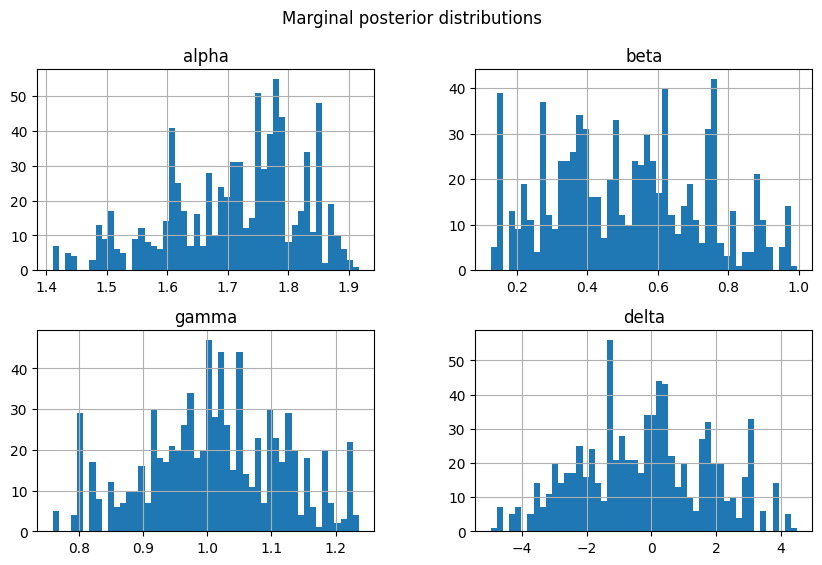

alpha  mean = 1.713,  95% CI = [1.483, 1.871]
beta   mean = 0.514,  95% CI = [0.155, 0.910]
gamma  mean = 1.012,  95% CI = [0.804, 1.223]
delta  mean = -0.173,  95% CI = [-3.704, 3.419]


In [7]:
descriptive(theta_posterior_s4)

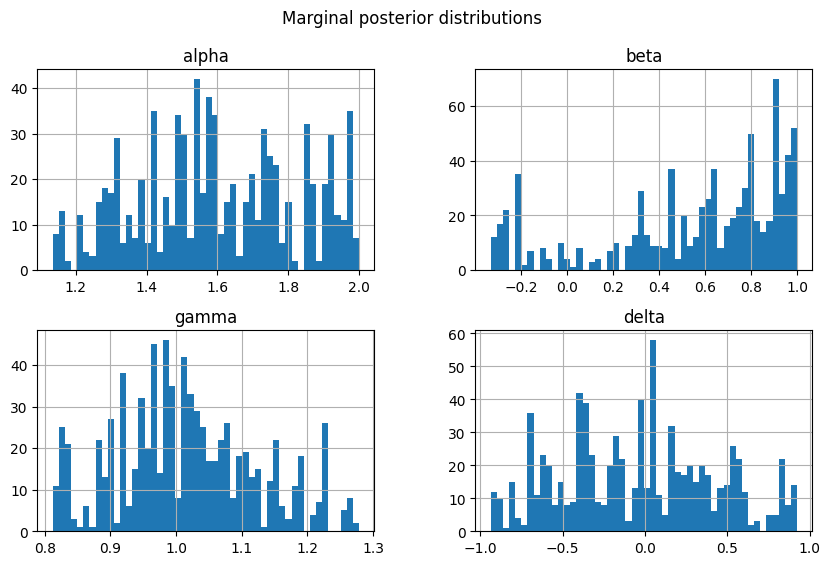

alpha  mean = 1.601,  95% CI = [1.166, 1.980]
beta   mean = 0.547,  95% CI = [-0.298, 0.986]
gamma  mean = 1.015,  95% CI = [0.822, 1.229]
delta  mean = -0.044,  95% CI = [-0.866, 0.856]


In [5]:
descriptive(theta_posterior_s3)


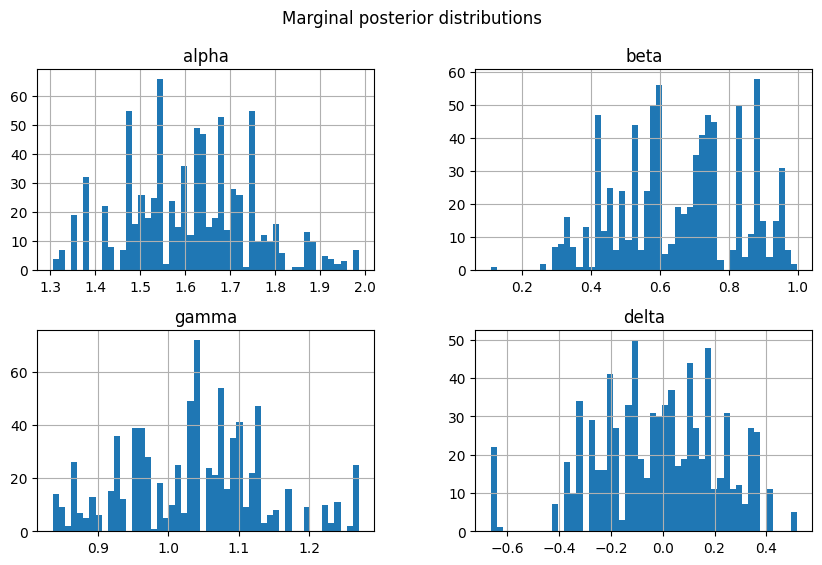

alpha  mean = 1.611,  95% CI = [1.354, 1.911]
beta   mean = 0.656,  95% CI = [0.329, 0.951]
gamma  mean = 1.038,  95% CI = [0.849, 1.264]
delta  mean = -0.014,  95% CI = [-0.663, 0.374]


In [219]:
descriptive(theta_posterior_s2)

d'apres les graphiques on voit s4 est optimale non seulement car epsilon est plus petit donc la précision plus grande de l estimateur à posteriori, mais aussi on le voit dans les intervalles de confiance et moyennes de S4 qui se rapprochent de la réalité , or l'utilisation de S2, s3 est plus optimale pour delta
